# **Klasifikasi Jenis Sampah dengan InceptionV3 - CNN**
---

In [1]:
# File operations and data manipulation
import os, zipfile, shutil
# from google.colab import drive
from shutil import copyfile

# Random number generation and numerical computations
import random
import numpy as np

# Visualization library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Deep learning framework and its modules
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Ignore warnings during execution
import warnings
warnings.filterwarnings("ignore")

# Print TensorFlow version
print(tf.__version__)

2.14.0


## **Dataset Collection**
---

### Def list_directories
---

In [2]:
def list_directories(root_path):
  for rootdir, dirs, files in os.walk(root_path):
    for subdir in dirs:
      print(os.path.join(rootdir, subdir))

### Download Data
---

In [3]:
!wget --no-check-certificate \
  https://github.com/mrgsrylm/KlasifikasiSampah/releases/download/v1.0.0/data_organic_recyclable.zip \
  -O data_organic_recyclable.zip

!unzip data_organic_recyclable.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

### Dataset Source
---

In [4]:
DATASOURCE = 'DATASET'

## **Data Augmentation**
---

### Datagen from ImageDataGenerator
---

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.4,
                                   fill_mode = 'nearest',
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

### Datasets
---
Flow training, validation and test images in batches of 64 using datagen generator

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = os.path.join(DATASOURCE, 'TRAIN'),
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64,
                                                   subset = 'training')

validation_dataset = valid_datagen.flow_from_directory(directory = os.path.join(DATASOURCE, 'TRAIN'),
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64,
                                                  subset = 'validation')

test_dataset = test_datagen.flow_from_directory(directory = os.path.join(DATASOURCE, 'TEST'),
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 64)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


## **Model Building**
---
Create Model using Convolutional Neural Network Basic Architecture

### Create InceptionV3 CNN Architecture (with Transfer Learning
---

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

### Add Optimizer then compile model
---

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = [tf.keras.metrics.AUC(name = 'auc')])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

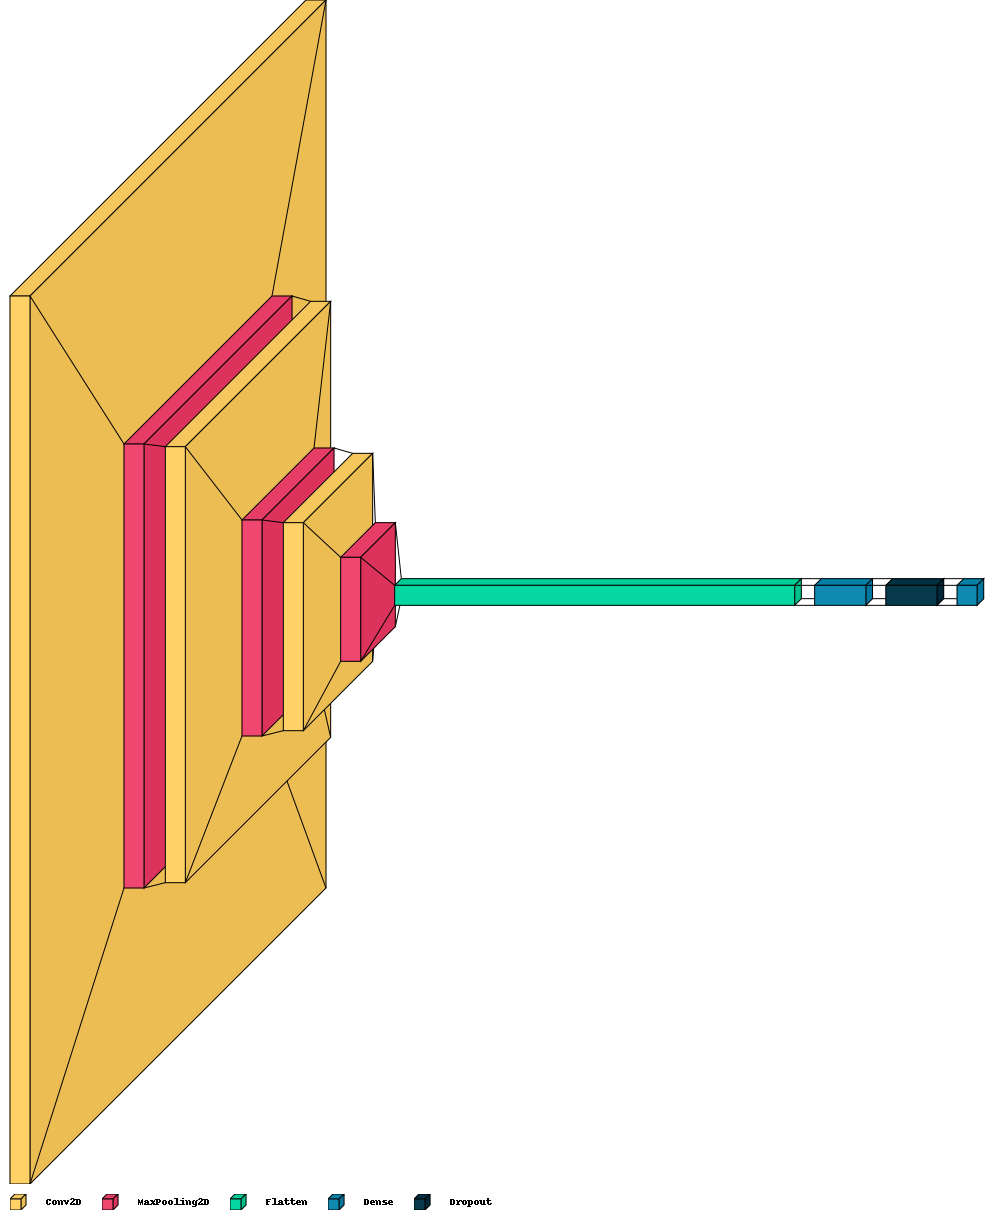

In [13]:
!pip install visualkeras
from visualkeras import layered_view
layered_view(model, legend=True, spacing=20)

## **Model Training**
---

In [14]:
monitor = EarlyStopping(monitor='val_auc', patience=15,
                        verbose=1, mode='max',restore_best_weights=True)
# Defining Callbacks

filepath = './model_cnn_klasifikasi_sampah.hdf5'
checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [monitor, checkpoint]

In [15]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=20,
                    verbose=1, callbacks=callback_list)

Epoch 1/20
283/283 [==============================] - ETA: 0s - loss: 0.4960 - auc: 0.8648
Epoch 1: val_auc improved from -inf to 0.88546, saving model to ./model_cnn_klasifikasi_sampah.hdf5
283/283 [==============================] - 276s 918ms/step - loss: 0.4960 - auc: 0.8648 - val_loss: 0.4298 - val_auc: 0.8855
Epoch 2/20
283/283 [==============================] - ETA: 0s - loss: 0.4051 - auc: 0.8989
Epoch 2: val_auc did not improve from 0.88546
283/283 [==============================] - 250s 883ms/step - loss: 0.4051 - auc: 0.8989 - val_loss: 0.4405 - val_auc: 0.8780
Epoch 3/20
283/283 [==============================] - ETA: 0s - loss: 0.3936 - auc: 0.9048
Epoch 3: val_auc improved from 0.88546 to 0.89504, saving model to ./model_cnn_klasifikasi_sampah.hdf5
283/283 [==============================] - 257s 906ms/step - loss: 0.3936 - auc: 0.9048 - val_loss: 0.4137 - val_auc: 0.8950
Epoch 4/20
283/283 [==============================] - ETA: 0s - loss: 0.3805 - auc: 0.9104
Epoch 4: val

## **Model Evaluation**
---

### Plotting accuracy and loss Model
---

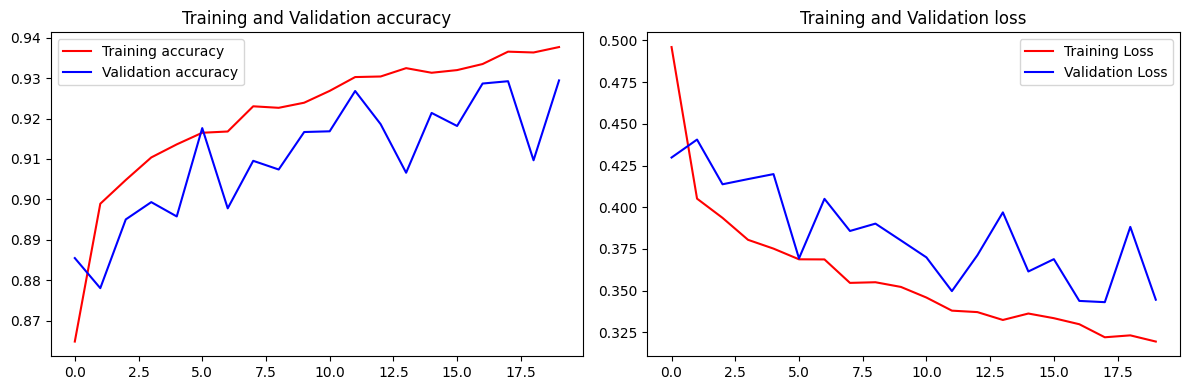

In [16]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Grapich
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(epochs, acc, 'r', label='Training accuracy')
axes[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axes[0].set_title('Training and Validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'r', label='Training Loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation Loss')
axes[1].set_title('Training and Validation loss')
axes[1].legend()

plt.tight_layout()
plt.show()

### Validation Accuracy
---

In [17]:
loss, accuracy = model.evaluate_generator(validation_dataset, steps=10, verbose=0)

print('Validation Accuracy: %.3f%%' % (accuracy * 100))
print('Validation Loss: %.3f%%' % (loss * 100))


Validation Accuracy: 92.322%
Validation Loss: 36.667%


### Test Accuracy
---

In [18]:
loss, accuracy = model.evaluate(test_dataset)

print('Test Accuracy: %.3f%%' % (accuracy * 100))
print('Test Loss: %.3f%%' % (loss * 100))

40/40 [==============================] - 6s 158ms/step - loss: 0.2969 - auc: 0.9472
Test Accuracy: 94.716%
Test Loss: 29.688%


## **Model Testing**
---

### Prediction
---

2/2 [==============================] - 0s 19ms/step
Prediction Accuracy: 100.0%


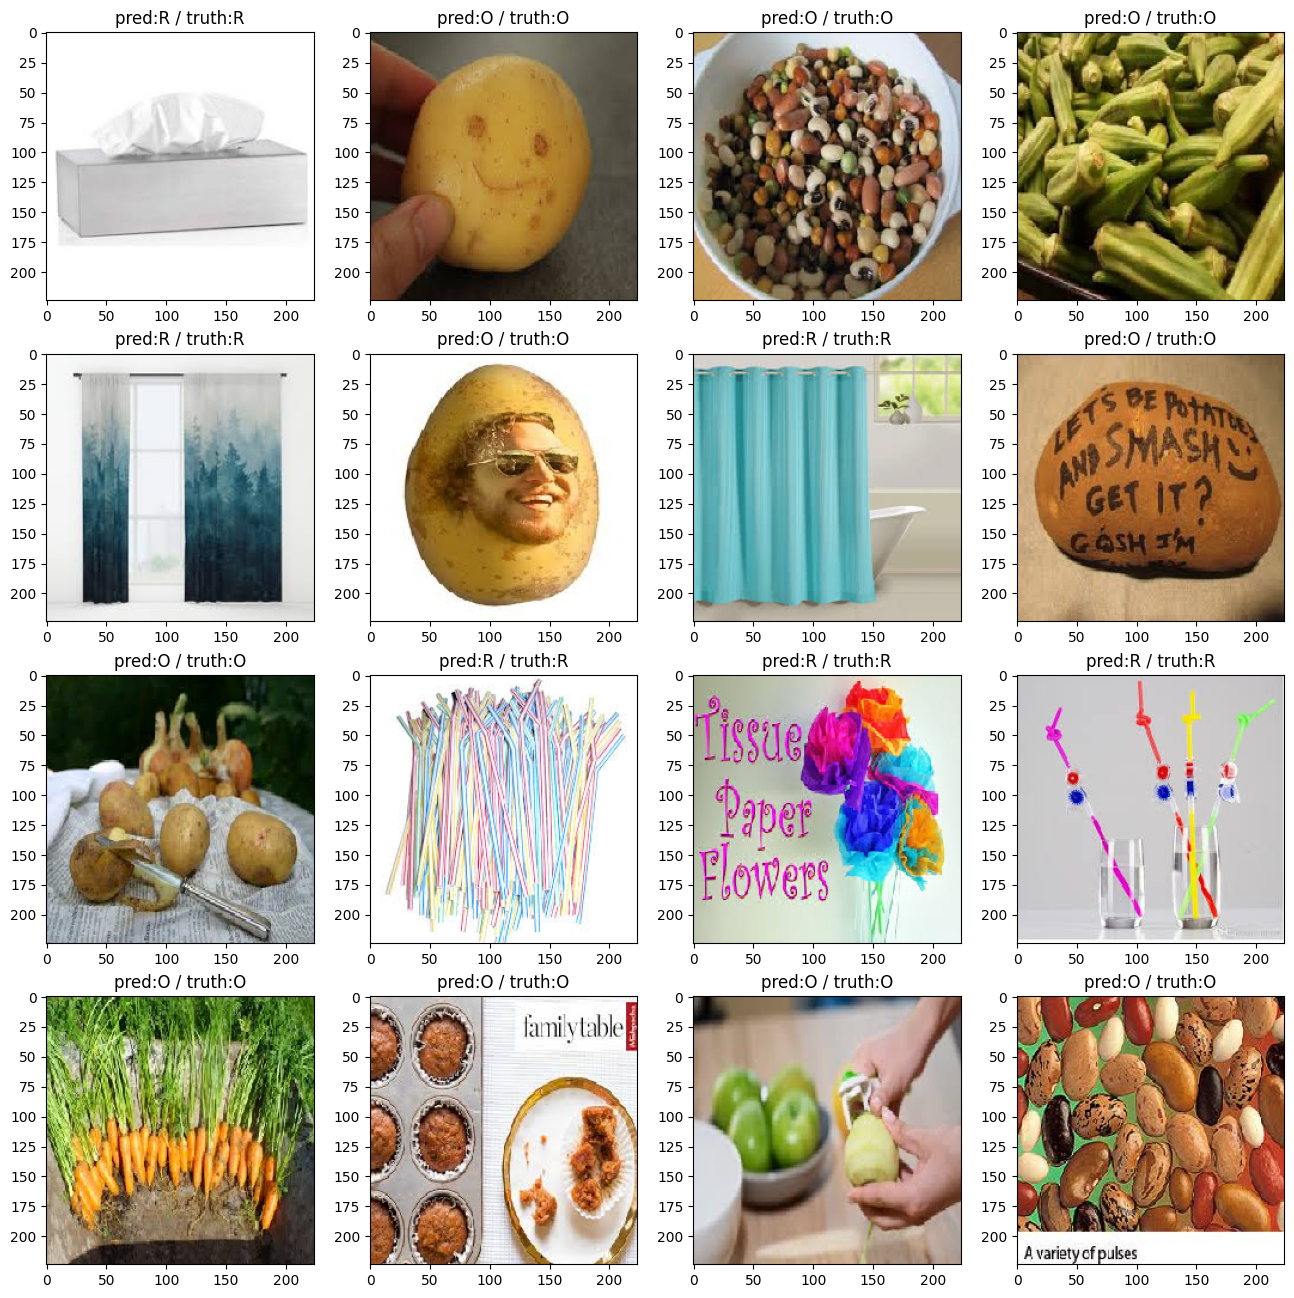

In [19]:
test_x, test_y = test_dataset.__getitem__(1)

labels = test_dataset.class_indices
labels = dict((v, k) for k, v in labels.items())

y_pred = model.predict(test_x)

plt.figure(figsize=(16, 16))
n = 16
count = 0

for i in range(n):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(y_pred[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
    if np.argmax(y_pred[i]) == np.argmax(test_y[i]):
        count += 1

accuracy = count / n * 100

print('Prediction Accuracy: {}%'.format(accuracy))

### Report
---

In [35]:
from sklearn.metrics import classification_report

test_x, test_y = test_dataset.__getitem__(1)

labels = test_dataset.class_indices
labels = dict((v, k) for k, v in labels.items())

y_pred = model.predict(test_x)

y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(test_y, axis=1)

print("Classification Report: ")
print(classification_report(true_classes, y_pred_classes, target_names=labels.values()))

2/2 [==============================] - 0s 12ms/step
Classification Report: 
              precision    recall  f1-score   support

           O       0.97      0.85      0.91        34
           R       0.85      0.97      0.91        30

    accuracy                           0.91        64
   macro avg       0.91      0.91      0.91        64
weighted avg       0.91      0.91      0.91        64



## **Model Storing**
---

### Save Model (h5)
---

In [22]:
!mkdir -p "saved_model"
!mkdir -p "tflite_model"
# model.save('saved_model/model_cnn_klasifikasi_jenis_sampah.h5')
shutil.copy('model_cnn_klasifikasi_sampah.hdf5', 'saved_model/model_cnn_klasifikasi_jenis_sampah.h5')

'saved_model/model_cnn_klasifikasi_jenis_sampah.h5'

### Save Model (TFLite)
---

In [23]:
tf.saved_model.save(model, export_dir="saved_model")

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_inception = converter.convert()

In [25]:
import pathlib
tflite_model_file = pathlib.Path("tflite_model/model_cnn_klasifikasi_jenis_sampah.tflite")
tflite_model_file.write_bytes(tflite_model_inception)

44408464

### Save Model to Google Drive
---

In [26]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [29]:
# Model
source_saved_model = "/content/saved_model"
destination_saved_model = "/content/drive/My Drive/klasifikasi_sampah/jenis_sampah/cnn/saved_model"
shutil.copytree(source_saved_model, destination_saved_model)

'/content/drive/My Drive/klasifikasi_sampah/jenis_sampah/cnn/tflite_model'

In [33]:
source_tflite_model = "/content/tflite_model"
destination_tflite_model = "/content/drive/My Drive/klasifikasi_sampah/jenis_sampah/cnn/tflite_model"
shutil.copytree(source_tflite_model, destination_tflite_model)

'/content/drive/My Drive/klasifikasi_sampah/jenis_sampah/cnn/tflite_model'

## Conclusion
---
1. Training Accuracy:
2. Validation Accuracy:
3. Testing Accuracy: